(learning)=
# Deep learning with Bayesian predictive coding

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.5-Learning.ipynb)

In [1]:
import sys

from IPython.utils import io

if "google.colab" in sys.modules:
    with io.capture_output() as captured:
        ! pip uninstall -y jax jaxlib
        ! pip install pyhgf watermark jax[cuda12]==0.4.31

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import random
from jax.random import PRNGKey
import treescope
from pyhgf import load_data
from pyhgf.model import Network
from pyhgf.utils.sample import sample

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

treescope.basic_interactive_setup(autovisualize_arrays=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The hierarchical Gaussian filter is built on top of a generative model that is governed by Gaussian random walks. As such, this model is mostly used to model the time-resolved evolution of beliefs in volatile environments. But the framework can easily extend to traditional applications of predictive coding, such as deep neural networks, where the variational message passing replaces the use of gradient descent during training.

In this notebook, we start from the foundational application of predictive coding networks as a replacement for backpropagation {cite:p}`Song2024` based on **prospective configuration**, where the most likely neural activation is inferred before weight updates. We show that the variational updates that follow the prediction errors can replace prospective configuration based on gradient descent over the energy function of a predictive coding network, and validate this approach on the "bear example" from {cite:p}`Song2024`.

```{figure} https://iiif.elifesciences.org/lax/27879%2Felife-27879-fig1-v3.tif/full/1500,/0/default.jpg
---
name: task
---
Learning with prospective configuration.

```

## Prospective configuration avoids interference during learning

In [3]:
# here x represents the visual input (River / No River)
x = np.array([1.0, 1.0] * 60)
x += np.random.normal(size=x.shape) / 100

# y represents the auditory and olfactory stimuli
y = np.array([
    x, 
    np.concat([np.array([1.0, 1.0] * 20), np.array([-1.0, -1.0] * 20), np.array([1.0, 1.0] * 20)]) + np.random.normal(size=x.shape) / 100
]).T

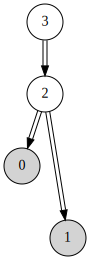

In [5]:
# We start by defining a simple network with two binary branches
network = (
    Network(update_type="unbounded")
    .add_nodes(n_nodes=2, precision=2.0, expected_precision=2.0)
    .add_nodes(value_children=[0, 1], autoconnection_strength=0, coupling_fn=(jnp.tanh, jnp.tanh))
    .add_nodes(value_children=2, autoconnection_strength=0, coupling_fn=(jnp.tanh, ))
)
network.plot_network()

Deep networks trained for classification purposes differ from other predictive coding networks as both roots and leaves should receive inputs (predictors and outcomes, respectively).

In [6]:
network.train(
    x=x,
    y=y,
    inputs_x_idxs=(3,),
    inputs_y_idxs=(0, 1),
);

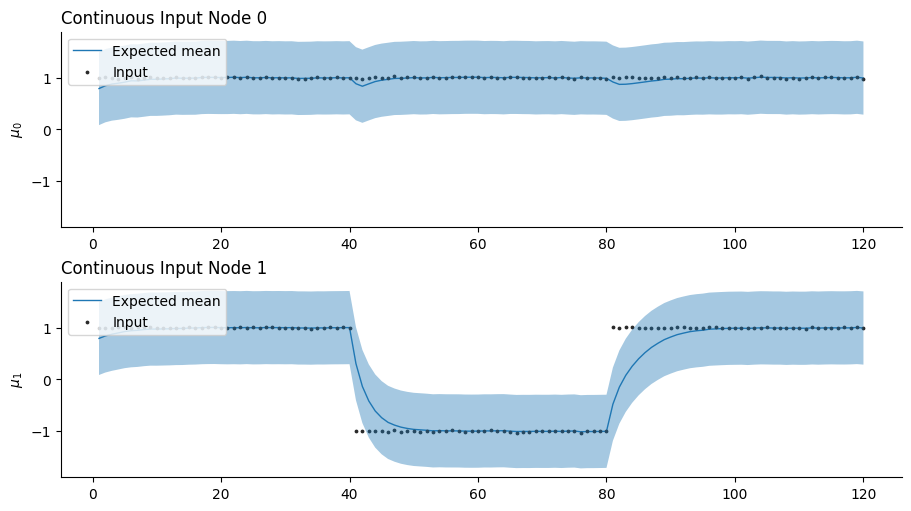

In [7]:
_, axs = plt.subplots(figsize=(9, 5), nrows=2, sharey=True)

network.plot_nodes(0, show_surprise=False, axs=axs[0])
network.plot_nodes(1, show_surprise=False, axs=axs[1])

sns.despine();

This example illustrates the effectiveness of the variational update to replace the prospective configuration step based on gradient descent. As new observations contradict the expected outcomes (i.e., observing the river without hearing the water, from trials 40 to 80 in the bottom panel), the network efficiently reorganizes without interfering with other predictions (i.e,. still expecting smelling the salmon while seeing the water, top panel, trials 40 to 80).

## Controlling the depth of weight updates with input precision

One natural consequence that emerges from this framework is that neural activations are defined by their precision, and as a result, the precision of the inputs (both predictors and outcomes) controls the strengths of prediction errors and the amplitude of weight updates in the vicinity of information flows. For example, more precise outcomes will guide weight updates to be larger at the nodes close to the inputs, and a more precise predictor will guide weight updates to be larger close to the internal representation.

We can simulate this behavior with a deep stack of hidden nodes whose predictors and outcomes differ, which forces the network to reorganize. Here, we show that the balance of precision between predictors and outcomes shapes the depth of weight updates.

In [8]:
def linear(x):
    return x

In [9]:
x = np.array([1.0] * 60)
x += np.random.normal(size=x.shape) / 100

y = np.array([0.0] * 60)
y += np.random.normal(size=y.shape) / 100

In [10]:
# We start by defining a simple network with two binary branches
high_predictor_precision_network = (
    Network(update_type="unbounded")
    .add_nodes(n_nodes=1, precision=1e3, expected_precision=1e3)
    .add_nodes(value_children=0, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=1, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=2, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=3, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0, precision=1, expected_precision=1)
    .add_nodes(volatility_children=1)
    .add_nodes(volatility_children=2)
    .add_nodes(volatility_children=3)
)

# We start by defining a simple network with two binary branches
high_outcome_precision_network = (
    Network()
    .add_nodes(n_nodes=1, precision=.1, expected_precision=.1)
    .add_nodes(value_children=0, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=1, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=2, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0,)
    .add_nodes(value_children=3, coupling_fn=(linear, ), tonic_volatility=-2.0, autoconnection_strength=0, precision=1e3, expected_precision=1e3)
    .add_nodes(volatility_children=1)
    .add_nodes(volatility_children=2)
    .add_nodes(volatility_children=3)
)

In [11]:
high_predictor_precision_network.train(
    x=x,
    y=y,
    inputs_x_idxs=(4,),
    inputs_y_idxs=(0,),
);

high_outcome_precision_network.train(
    x=x,
    y=y,
    inputs_x_idxs=(4,),
    inputs_y_idxs=(0,),
);

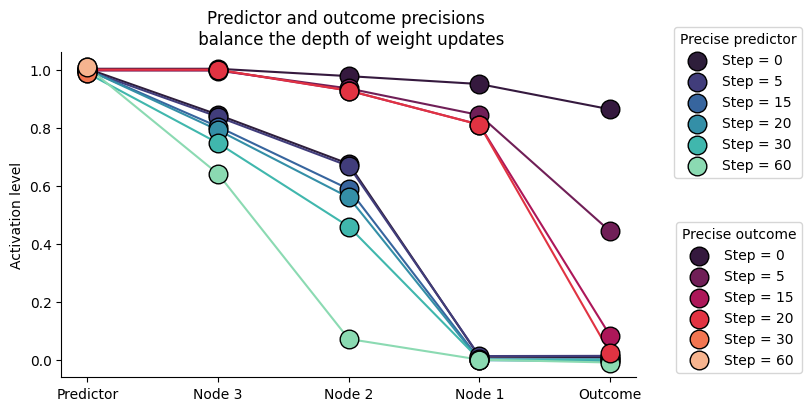

In [12]:
_, ax = plt.subplots(figsize=(8, 4))

# high prediction precision
# -------------------------
palette = sns.color_palette("mako", 6)
handles, labels = [], []
for color, time_step in zip(palette, [0, 5, 15, 20, 30, 60]):
    expected_means = [high_predictor_precision_network.node_trajectories[i]["expected_mean"][time_step] for i in range(5)]
    scatterplot = ax.scatter(range(4, -1, -1), expected_means, s=180, color=color, label=time_step, edgecolor="k")
    handles.append(scatterplot)
    labels.append(f"Step = {time_step}")
    ax.plot(range(4, -1, -1), expected_means, color=color, zorder=-1)

first_legend = ax.legend(handles=handles, labels=labels, title="Precise predictor", bbox_to_anchor=(1.3, 1.1))
ax.add_artist(first_legend)

# high outcome precision
# ----------------------
palette = sns.color_palette("rocket", 6)
handles, labels = [], []
for color, time_step in zip(palette, [0, 5, 15, 20, 30, 60]):
    expected_means = [high_outcome_precision_network.node_trajectories[i]["expected_mean"][time_step] for i in range(5)]
    scatterplot = ax.scatter(range(4, -1, -1), expected_means, s=180, color=color, label=time_step, edgecolor="k")
    handles.append(scatterplot)
    labels.append(f"Step = {time_step}")
    ax.plot(range(4, -1, -1), expected_means, color=color, zorder=-1)
second_legend = ax.legend(handles=handles, labels=labels, title="Precise outcome", bbox_to_anchor=(1.3, 0.5))

plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Predictor", "Node 3", "Node 2", "Node 1", "Outcome"])
ax.set(ylabel="Activation level", title="Predictor and outcome precisions \n balance the depth of weight updates")

sns.despine()

plt.savefig("deep_networks.png", dpi=300)

# System configuration

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Oct 02 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.4.0

pyhgf : 0.2.7
jax   : 0.4.31
jaxlib: 0.4.31

IPython   : 9.4.0
seaborn   : 0.13.2
matplotlib: 3.10.1
platform  : 1.0.8
treescope : 0.1.10
pyhgf     : 0.2.7
sys       : 3.12.10 (main, Apr  9 2025, 04:03:51) [Clang 20.1.0 ]
jax       : 0.4.31
numpy     : 2.2.5

Watermark: 2.5.0

